# Histopathological Cancer Detection - Binary Classification Kaggle Challenge

<img src="https://miro.medium.com/max/1200/1*jcZLpgh3gppeFFgcpFSP0w.jpeg" width="800">

* This workbook illustrates my attempt to solve the [Histopathological Cancer Detection Challenge](https://www.kaggle.com/c/histopathologic-cancer-detection) on Kaggle, which is a **binary classification** problem.
* In this workbook I'll be using Pytorch with a custom Convolutional Neural Network (CNN).
* This workbook also shows you how you can connect to Kaggle from a Colab Notebook and download dataset(s) for use locally - we will be downloading the Fruits360 datset from Kaggle to our Colab environment.

<font color='yellow'>It is recommended that you run this notebook on a GPU only, like ones available on Google Colab or Kaggle</font>

Following cell sets up access to our Google Drive

In [1]:
# set this flag to True when you run this Notebook on Google Collaboratory
USE_COLAB = True

import os, sys

#@see: https://colab.research.google.com/drive/1srw_HFWQ2SMgmWIawucXfusGzrj1_U0q
if USE_COLAB:
    # Load the Drive helper and mount
    from google.colab import drive

    # We mount our Googgle Drive to this foloder - following line will prompt for authorization.
    gdrive_mount_point = '/content/drive/'
    drive.mount(gdrive_mount_point)
    grive_path = os.path.join(gdrive_mount_point, "MyDrive/")
    print('Your Google Drive is mounted at ', grive_path)
    COLAB_NOTEBOOKS_PATH = os.path.join(grive_path, "Colab Notebooks/")
    PYTORCH_COLAB_NOTEBOOKS_PATH = os.path.join(COLAB_NOTEBOOKS_PATH, 'Pytorch')
    
    if os.path.exists(PYTORCH_COLAB_NOTEBOOKS_PATH):
        print('You Pytorch Colab notebooks are available at ', PYTORCH_COLAB_NOTEBOOKS_PATH)

        # append our Google Drive folder to module search 
        sys.path.append(PYTORCH_COLAB_NOTEBOOKS_PATH)
        print('NOTE: {} is appended to sys.path!'.format(PYTORCH_COLAB_NOTEBOOKS_PATH))
        # and test it
        import pytorch_toolkit as pytk
        MODEL_SAVE_DIR = os.path.join(PYTORCH_COLAB_NOTEBOOKS_PATH, 'model_states')
    else:
        raise IOError(f"Unable to mount Google Drive! {PYTORCH_COLAB_NOTEBOOKS_PATH} does not exist.")
else:
    MODEL_SAVE_DIR = os.path.join('.','model_states')
    
if not os.path.exists(MODEL_SAVE_DIR):
    os.mkdir(MODEL_SAVE_DIR)
print(f'MODEL_SAVE_DIR = {MODEL_SAVE_DIR}')

Mounted at /content/drive/
Your Google Drive is mounted at  /content/drive/MyDrive/
You Pytorch Colab notebooks are available at  /content/drive/MyDrive/Colab Notebooks/Pytorch
NOTE: /content/drive/MyDrive/Colab Notebooks/Pytorch is appended to sys.path!
MODEL_SAVE_DIR = /content/drive/MyDrive/Colab Notebooks/Pytorch/model_states


## Downloading the dataset from Kaggle
You can download datasets directly from Kaggle into a Colab environment by running the following steps:
* Login to your Kaggle account and _create a new API Token_ from your profile page (click the `Create API Token` button and download the `kaggle.json` file locally i.e. to your disk.
* Upload the `kaggle.json` that you downloaded to Colab  and move the file to `~/.kaggle/kaggle.json`
* Install Python packages `kaggle` and `kaggle-cli` that needed to access Kaggle programatically. These can be installed using `pip`
* Now you can access datasets on Kaggle
    * Run `!kaggle datasets list` shell command to list all available datasets (may no be such a useful command!)
    * Run `!datasets list -s <<dataset_name>>` to search for a dataset (e.g. for the Malaria dataset, I used `kaggle list -s malaria`)
    * Copy dataset locally using `!kaggle datasets download -d <<full_path_of_dataset>> -p <<target_folder_path>>`



In [3]:
# so I uploaded my kaggle.json to my Google drive, which I can easily copy into Colab workspace :)
!ls -al "/content/drive/My Drive/Colab Notebooks/kaggle.json"

-rw------- 1 root root 63 Jul 31  2020 '/content/drive/My Drive/Colab Notebooks/kaggle.json'


In [4]:
# Run this cell to copy the uploaded kaggle.json file to ~/.kaggle/kaggle.json 
# Kaggle expects the token file to be located here!!
!mkdir -p ~/.kaggle
!cp "/content/drive/My Drive/Colab Notebooks/kaggle.json" ~/.kaggle/
# give "me" full access to kaggle.json (i.e. read/write & execute)
!chmod 600 ~/.kaggle/kaggle.json
# confirm that ~/.kaggle folder has kaggle.json file
!ls ~/.kaggle

kaggle.json


Install the `kaggle` package, which will allow you to download Kaggle datasets into your Colab environment.

In [5]:
# install Python packages require to access Kaggle datasets
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 2.9 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=e16107452a37b7a099f1994548da9a193ef2f07f62844dfae11b7ba86e413e41
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [6]:
# Vola! You now have access to Kaggle datasets

# to list **all** the datasets available on Kaggle, run the following shell command
#!kaggle datasets list

In [7]:
# now you can use the following command to download the complete dataset to the /tmp folder (-p /tmp)

#NOTE: images zip file is nearly 6Gb!!
!kaggle competitions download -c histopathologic-cancer-detection -p /tmp

100% 6.29G/6.31G [02:19<00:00, 59.4MB/s]
100% 6.31G/6.31G [02:19<00:00, 48.4MB/s]


In [8]:
# check if it downloaded
!ls /tmp/*.zip

/tmp/histopathologic-cancer-detection.zip


Now that we have _downloaded_ data from Kaggle to our local Colab environment, let's unzip the contents.

In [9]:
# and let us unzip histopathologic-cancer-detection.zip to /tmp folder
# NOTE: this process takes some time, even on Google infra ;)
import os, shutil
import zipfile

zip_file_path = '/tmp/histopathologic-cancer-detection.zip'
assert os.path.exists(zip_file_path)

if not os.path.exists('/tmp/histo'):
    os.mkdir('/tmp/histo')

# extract all files to /tmp
print('Source zip: %s' % zip_file_path)
print('Extracting all imagefiles...', end='', flush=True)
zip_ref = zipfile.ZipFile(zip_file_path, 'r')

zip_ref.extractall('/tmp/histo')
zip_ref.close()
print('done!', flush=True)

Source zip: /tmp/histopathologic-cancer-detection.zip
Extracting all imagefiles...done!


In [10]:
# now in the Colab files pane you should see sub-folders & files under /tmp/histo
# our training images are in /tmp/histo/train & our labels dataframe is /tmp/histo/

In [11]:
print(f"Found {len(os.listdir('/tmp/histo/train'))} training images and {len(os.listdir('/tmp/histo/test'))} testing images")

Found 220025 training images and 57458 testing images


## About the Kaggle Dataset

The [Histopathologic Cancer Detection](https://www.kaggle.com/c/histopathologic-cancer-detection/data) Kaggle dataset contains 2 folders:
* train 
* test

and a file `train_labels.csv`

There are 220,025 training color images (TIF images without extensions), each `96x96` pixels. The `train_labels.csv` provides mapping between image file name & label [`1 malignant` and `0 benign`]. No labels are provided for the `/tmp/histo/test` images. We will _ignore_ these in this workbook - they are meant for competition submission.

In [12]:
import warnings
warnings.filterwarnings('ignore')

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from PIL import Image
%matplotlib inline

# tweaks for libraries
np.set_printoptions(precision=6, linewidth=1024, suppress=True)
plt.style.use('seaborn')
sns.set(style='darkgrid', context='notebook',font_scale=1.10)

# Pytorch imports
import torch
gpu_available = torch.cuda.is_available()
print('Using Pytorch version %s. GPU %s available' % (torch.__version__, "IS" if gpu_available else "IS **NOT**"))
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch import optim
from torch.utils.data.dataset import Dataset
from torchsummary import summary
# My helper functions for training/evaluating etc.
import pytorch_toolkit as pytk


# to ensure that you get consistent results
# @see: https://discuss.pytorch.org/t/reproducibility-over-different-machines/63047
seed = 123
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed);

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False

Using Pytorch version 1.10.0+cu111. GPU IS available


In [13]:
IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS, NUM_CLASSES = 96, 96, 3, 2

### Exploring the dataset

In [14]:
DATA_FOLDER = '/tmp/histo'

In [15]:
df = pd.read_csv(os.path.join(DATA_FOLDER, 'train_labels.csv'))
df.head()

id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

In [16]:
len(df[df.isnull().any(axis=1)])

0

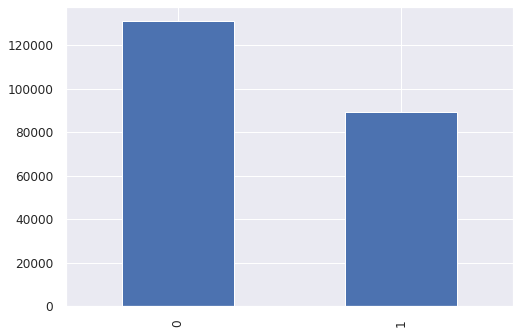

In [17]:
# let's check the distribution of target labels
df['label'].value_counts().plot(kind='bar');

Notice that the data is imbalanced, with malignant (=1) cases almost 3/4 of benign (=0) cases. We will need to weight balance the optimizer.

In [18]:
# let's save the benign & malignant counts, which will help us weight balance the loss function
num_benign, num_malignant = np.bincount(df['label'])
print(f"Found {num_benign} benign cases and {num_malignant} cases in dataset")

Found 130908 benign cases and 89117 cases in dataset


In [19]:
def get_data():
    df = pd.read_csv('/tmp/histo/train_labels.csv')
    #df['label'].value_counts().plot(kind='bar', title="Diagnosis Distribution")
    #plt.show()

    # shuffle the dataframe
    df = df.sample(frac=1).reset_index(drop=True)
    print(f"Found {len(df[df.isnull().any(axis=1)])} after shuffling")

    # split into train/cross-val/test datasets (use stratify so we get a similar distribution)
    image_ids, labels = df['id'], df['label']
    X_train, X_test, y_train, y_test = \
      train_test_split(image_ids, labels, test_size=0.30, random_state=seed, stratify=labels)
    X_val, X_test, y_val, y_test = \
      train_test_split(X_test, y_test, test_size=0.20, random_state=seed, stratify=y_test)
    print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

    X_train_image_paths = [os.path.join(DATA_FOLDER, 'train', image_id + '.tif') for image_id in X_train.values]
    X_val_image_paths = [os.path.join(DATA_FOLDER, 'train', image_id + '.tif') for image_id in X_val.values]
    X_test_image_paths = [os.path.join(DATA_FOLDER, 'train', image_id + '.tif') for image_id in X_test.values]

    return (X_train_image_paths, y_train.values), (X_val_image_paths, y_val.values), \
        (X_test_image_paths, y_test.values)

In [20]:
def display_sample(sample_images, sample_labels, sample_predictions=None, grid_shape=(8, 8),
                   plot_title=None, fig_size=None):
    """ display a random selection of images & corresponding labels, optionally with predictions
        The display is laid out in a grid of num_rows x num_col cells
        If sample_predictions are provided, then each cell's title displays the prediction
        (if it matches actual) or actual/prediction if there is a mismatch
    """
    from PIL import Image
    import seaborn as sns

    num_rows, num_cols = grid_shape

    assert len(sample_images) == num_rows * num_cols

    # a dict to help encode/decode the labels
    LABELS = {
        1: 'Malignant',
        0: 'Benign'
    }

    with sns.axes_style("whitegrid"):
        sns.set_context("notebook", font_scale=1.1)
        sns.set_style({"font.sans-serif": ["Verdana", "Arial", "Calibri", "DejaVu Sans"]})

        f, ax = plt.subplots(num_rows, num_cols, figsize=((20, 20) if fig_size is None else fig_size),
                             gridspec_kw={"wspace": 0.02, "hspace": 0.25}, squeeze=True)
        # fig = ax[0].get_figure()
        f.tight_layout()
        f.subplots_adjust(top=0.95)

        for r in range(num_rows):
            for c in range(num_cols):
                image_index = r * num_cols + c
                ax[r, c].axis("off")

                # show selected image
                sample_image = sample_images[image_index]
                # got image as (NUM_CHANNELS, IMAGE_HEIGHT, IMAGE_WIDTH)
                sample_image = sample_image.transpose((1, 2, 0))
                #sample_image = sample_image * 0.5 + 0.5  # since we applied this normalization
                # sample_image *= 255.0

                ax[r, c].imshow(sample_image)

                if sample_predictions is None:
                    # show the actual labels in the cell title
                    title = ax[r, c].set_title("%s" % LABELS[sample_labels[image_index]])
                else:
                    # else check if prediction matches actual value
                    true_label = sample_labels[image_index]
                    pred_label = sample_predictions[image_index]
                    prediction_matches_true = (true_label == pred_label)
                    if prediction_matches_true:
                        # if actual == prediction, cell title is prediction shown in green font
                        title = LABELS[true_label]
                        title_color = 'g'
                    else:
                        # if actual != prediction, cell title is actua/prediction in red font
                        title = '%s\n%s' % (LABELS[true_label], LABELS[pred_label])
                        title_color = 'r'
                    # display cell title
                    title = ax[r, c].set_title(title)
                    plt.setp(title, color=title_color)
        # set plot title, if one specified
        if plot_title is not None:
            f.suptitle(plot_title)

        plt.show()
        plt.close()

In [21]:
class HistoDataset(Dataset):
    def __init__(self, image_paths, labels, transforms):
        self.image_paths = image_paths
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        """
        Open a PIL image, apply transforms (if any) & convert to Numpy array
        and return array and label at index
        """
        image_path = self.image_paths[index]
        assert (os.path.exists(image_path)), f'Invalid path - {image_path} does not exist!'
        img = Image.open(image_path)
        #if self.transforms is not None:
        img = self.transforms(img)
        #img = np.array(img).astype(np.float32)
        #img /= 255.0
        label = self.labels[index]
        #print(f"HistoDataset.__getitem__[{index}] -> image.shape: {img.shape} - label.shape: {label.shape}/value: {label}")
        return (img, label)  # will return tensors

In [22]:
def get_mean_std_dataset(ds):
    meanRGB = [np.mean(x, axis=(1,2)) for x, _ in ds]
    stdRGB = [np.std(x, axis=(1,2)) for x, _ in ds]

    meanR = np.mean([m[0] for m in meanRGB])
    meanG = np.mean([m[1] for m in meanRGB])
    meanB = np.mean([m[2] for m in meanRGB])

    stdR = np.std([s[0] for s in stdRGB])
    stdG = np.std([s[1] for s in stdRGB])
    stdB = np.std([s[2] for s in stdRGB])

    return (meanR, meanG, meanB), (stdR, stdG, stdB)    

In [23]:
(X_train_image_paths, y_train), (X_val_image_paths, y_val), \
        (X_test_image_paths, y_test) = get_data()

Found 0 after shuffling
(154017,) (154017,) (52806,) (52806,) (13202,) (13202,)


In [24]:
# train_dataset = HistoDataset(X_train_image_paths, y_train, transforms.ToTensor())
# (meanR, meanG, meanB), (stdR, stdG, stdB) = get_mean_std_dataset(train_dataset)
# print(f"meanR: {meanR:.4f} stdR: {stdR:.4f} - meanG: {meanG:.4f} stdG: {stdG:.4f} - meanB: {meanB:.4f} stdB: {stdB:.4f}")
# del train_dataset  # to save memory

In [25]:
# we are scaling all images to same size + converting them to tensors & normalizing data
xforms = {
    'train': transforms.Compose([
        #transforms.Resize((96,96)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(25),
        transforms.RandomResizedCrop(96,scale=(0.8,1.0),ratio=(1.0,1.0)),
        transforms.ToTensor(),
        # transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
    ]),
    'eval': transforms.Compose([
        #transforms.Resize((96,96)),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        #transforms.Resize((96,96)),
        transforms.ToTensor(),
    ]),
}

In [26]:
# define our datasets
train_dataset = HistoDataset(X_train_image_paths, y_train, xforms['train'])
eval_dataset = HistoDataset(X_val_image_paths, y_val, xforms['eval'])
test_dataset = HistoDataset(X_test_image_paths, y_test, xforms['test'])
print(len(train_dataset), len(X_train_image_paths), len(eval_dataset), len(X_val_image_paths), \
        len(test_dataset), len(X_test_image_paths))

154017 154017 52806 52806 13202 13202


Dataset: image.shape = torch.Size([64, 3, 96, 96]), labels.shape = torch.Size([64])


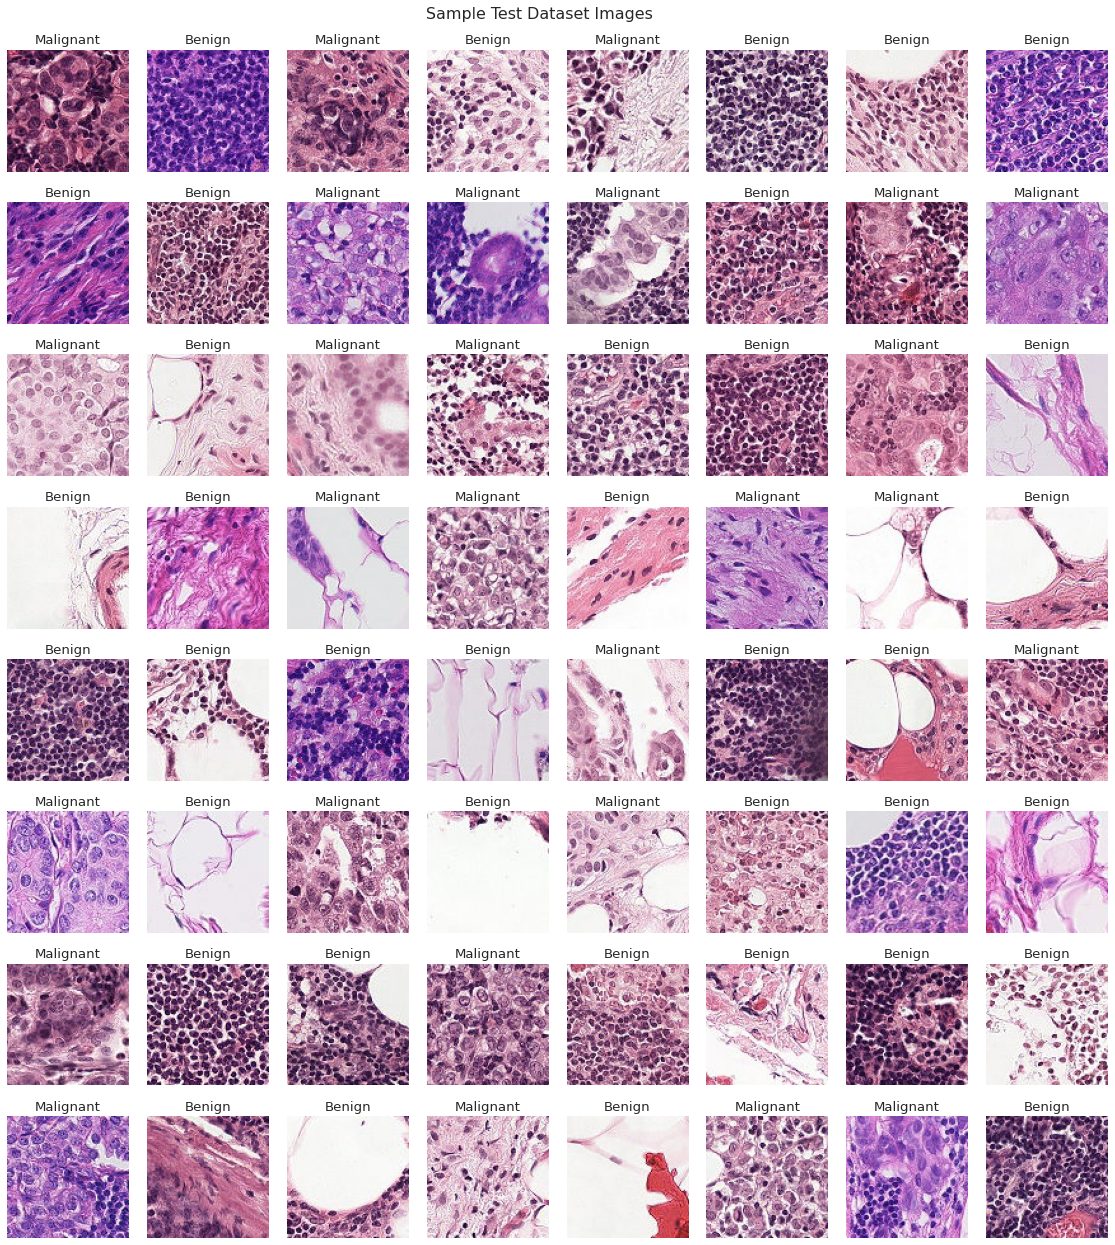

In [27]:
# let's view a sample of 64 images from the test dataset
loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)
data_iter = iter(loader)
sample_images, sample_labels = data_iter.next()  # fetch first batch of 64 images & labels
print(f'Dataset: image.shape = {sample_images.shape}, labels.shape = {sample_labels.shape}')
display_sample(sample_images.cpu().numpy(), sample_labels.cpu().numpy(), plot_title="Sample Test Dataset Images");

## Building the model

In [28]:
IMAGE_WIDTH, IMAGE_HEIGHT, NUM_CHANNELS, NUM_CLASSES = 96, 96, 3, 2
NUM_EPOCHS, BATCH_SIZE, LR_RATE, L2_REG = 100, 128, 3e-3, 0.0075
MODEL_SAVE_PATH = os.path.join(MODEL_SAVE_DIR, f"histo_{NUM_EPOCHS}.pyt")
print(MODEL_SAVE_PATH)

/content/drive/MyDrive/Colab Notebooks/Pytorch/model_states/histo_100.pyt


In [29]:
def build_model():
    net = nn.Sequential(
        pytk.Conv2d(NUM_CHANNELS, 8, 3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(8),
        nn.MaxPool2d(kernel_size=2, stride=2),

        pytk.Conv2d(8, 16, 3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.MaxPool2d(kernel_size=2, stride=2),

        pytk.Conv2d(16, 32, 3, padding=0),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(kernel_size=2, stride=2),

        pytk.Conv2d(32, 64, 3, padding=0),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Flatten(),

        nn.Linear(64*4*4, 512),
        nn.ReLU(),
        nn.Dropout(0.25),

        # nn.Linear(1024, 512),
        # nn.ReLU(),
        # nn.Dropout(0.25),

        nn.Linear(512, NUM_CLASSES),
        nn.LogSoftmax()  
    )
    model = pytk.PytkModuleWrapper(net)
    class_counts = [num_benign, num_malignant]
    weights = torch.FloatTensor(class_counts) / (num_benign + num_malignant)
    weights = weights.cuda() if torch.cuda.is_available() else weights.cpu()
    # since data is imbalanced, we need to apply weights to the loss function
    #criterion = nn.CrossEntropyLoss(weight=weights, reduction="sum")
    criterion = nn.NLLLoss(weight=weights, reduction="sum")
    optimizer = optim.Adam(params=model.parameters(), lr=LR_RATE, weight_decay=L2_REG)
    model.compile(loss=criterion, optimizer=optimizer, metrics=['acc'])
    return model, optimizer

In [30]:
model, optimizer = build_model()
print(model.summary((NUM_CHANNELS, IMAGE_HEIGHT, IMAGE_WIDTH)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 96, 96]             224
              ReLU-2            [-1, 8, 96, 96]               0
       BatchNorm2d-3            [-1, 8, 96, 96]              16
         MaxPool2d-4            [-1, 8, 48, 48]               0
            Conv2d-5           [-1, 16, 48, 48]           1,168
              ReLU-6           [-1, 16, 48, 48]               0
       BatchNorm2d-7           [-1, 16, 48, 48]              32
         MaxPool2d-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 32, 22, 22]           4,640
             ReLU-10           [-1, 32, 22, 22]               0
      BatchNorm2d-11           [-1, 32, 22, 22]              64
        MaxPool2d-12           [-1, 32, 11, 11]               0
           Conv2d-13             [-1, 64, 9, 9]          18,496
             ReLU-14             [-1, 6

In [31]:
# apply a learning rate scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=1)
#lr_scheduler = StepLR(optimizer, step_size=NUM_EPOCHS//5, gamma=0.5, verbose=1)

hist = model.fit_dataset(train_dataset, validation_dataset=eval_dataset, epochs=NUM_EPOCHS, 
                         batch_size=BATCH_SIZE, num_workers=5, lr_scheduler=lr_scheduler, 
                         verbose=1) #, report_interval=5)

Training on GPU...
Training on 154017 samples, cross-validating on 52806 samples
Epoch (  1/100): (154017/154017) -> loss: 23.7223 - acc: 0.8319 - val_loss: 21.1674 - val_acc: 0.8544 - lr: ['0.00300000']
Epoch (  2/100): (154017/154017) -> loss: 19.6876 - acc: 0.8633 - val_loss: 79.9785 - val_acc: 0.6854 - lr: ['0.00300000']
Epoch (  3/100): (154017/154017) -> loss: 18.0535 - acc: 0.8774 - val_loss: 31.1610 - val_acc: 0.7643 - lr: ['0.00300000']
Epoch (  4/100): (154017/154017) -> loss: 17.1226 - acc: 0.8860 - val_loss: 28.7157 - val_acc: 0.7908 - lr: ['0.00300000']
Epoch (  5/100): (154017/154017) -> loss: 16.6263 - acc: 0.8892 - val_loss: 38.6574 - val_acc: 0.7708 - lr: ['0.00300000']
Epoch (  6/100): (154017/154017) -> loss: 16.2418 - acc: 0.8922 - val_loss: 19.8328 - val_acc: 0.8727 - lr: ['0.00300000']
Epoch (  7/100): (154017/154017) -> loss: 15.9449 - acc: 0.8952 - val_loss: 21.7420 - val_acc: 0.8409 - lr: ['0.00300000']
Epoch (  8/100): (154017/154017) -> loss: 15.7010 - acc: 0

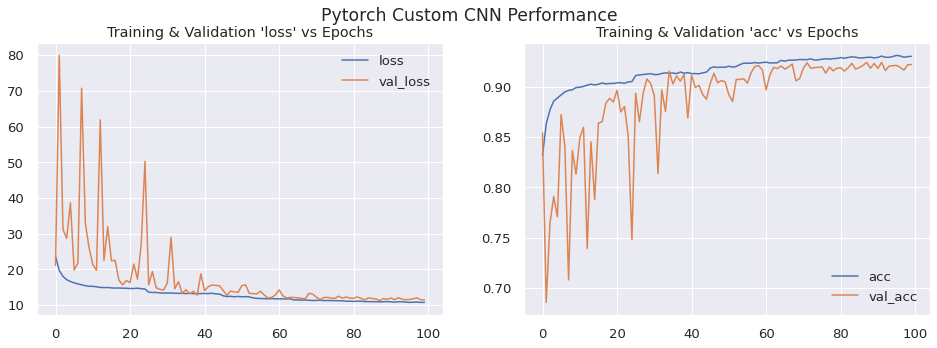

In [32]:
pytk.show_plots(hist, metric='acc', plot_title='Pytorch Custom CNN Performance')

In [33]:
# evaluate performance on train, cross-val & test data
loss, acc = model.evaluate_dataset(train_dataset)
print('Training data  -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model.evaluate_dataset(eval_dataset)
print('Cross-val data -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model.evaluate_dataset(test_dataset)
print('Testing data   -> loss: %.3f, acc: %.3f' % (loss, acc))

Evaluating (154017/154017) -> loss: 5.0311 - acc: 0.9356
Training data  -> loss: 5.031, acc: 0.936
Evaluating (52806/52806) -> loss: 5.7265 - acc: 0.9226
Cross-val data -> loss: 5.727, acc: 0.923
Evaluating (13202/13202) -> loss: 5.6067 - acc: 0.9251
Testing data   -> loss: 5.607, acc: 0.925


**Observations:**

>Configuration | Training Acc | Cross-Val Acc | Testing Acc 
>---:|---:|---:|---:|
>**25 Epochs**| ? %|? %|? %|
>**50 Epochs**|92.9%|91.82%|91.86%|
>**100 Epochs**|93.6%|92.3%|92.51%|


* **Blah!! **

In [45]:
model.save(MODEL_SAVE_PATH)
del model

AttributeError: ignored

## Running Predictions

In [ ]:
model, optimizer = build_model()
model.load(MODEL_SAVE_PATH)  # and load state from disk
print(model.summary((NUM_CHANNELS, IMAGE_HEIGHT, IMAGE_WIDTH)))

In [40]:
# display sample from test dataset
print(f'Running predictions on {len(test_dataset)} test records....')

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
actuals, predictions = [], []

for batch_no, (images, labels) in enumerate(test_loader):
    # images, labels = data_iter.next()  # fetch first batch of 64 images & labels
    preds = model.predict(images)
    actuals.extend(labels.cpu().numpy().ravel())
    predictions.extend(np.argmax(preds, axis=1).ravel())

actuals = np.array(actuals)
predictions = np.array(predictions)

print('Sample actual values & predictions...')
print('  - Acutal values: ', actuals[:32])
print('  - Predictions  : ', predictions[:32])
correct_preds = (actuals == predictions).sum()
acc = correct_preds / len(actuals)
print('  We got %d of %d correct (%.3f accuracy)' % (correct_preds, len(actuals), acc))

from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(actuals, predictions))
# pyt.plot_confusion_matrix(confusion_matrix(actuals, predictions), ['Healthy', 'Infected'])

Running predictions on 13202 test records....
Sample actual values & predictions...
  - Acutal values:  [1 0 1 0 1 0 0 0 0 0 1 1 1 0 1 1 1 0 1 1 0 0 1 0 0 0 1 1 0 1 1 0]
  - Predictions  :  [1 0 1 0 0 0 0 0 0 0 1 1 1 0 1 1 1 0 1 0 0 0 1 0 0 0 1 1 0 1 1 0]
  We got 12212 of 13202 correct (0.925 accuracy)
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      7855
           1       0.96      0.85      0.90      5347

    accuracy                           0.93     13202
   macro avg       0.93      0.91      0.92     13202
weighted avg       0.93      0.93      0.92     13202



torch.Size([64, 3, 96, 96]) torch.Size([64]) (64,)


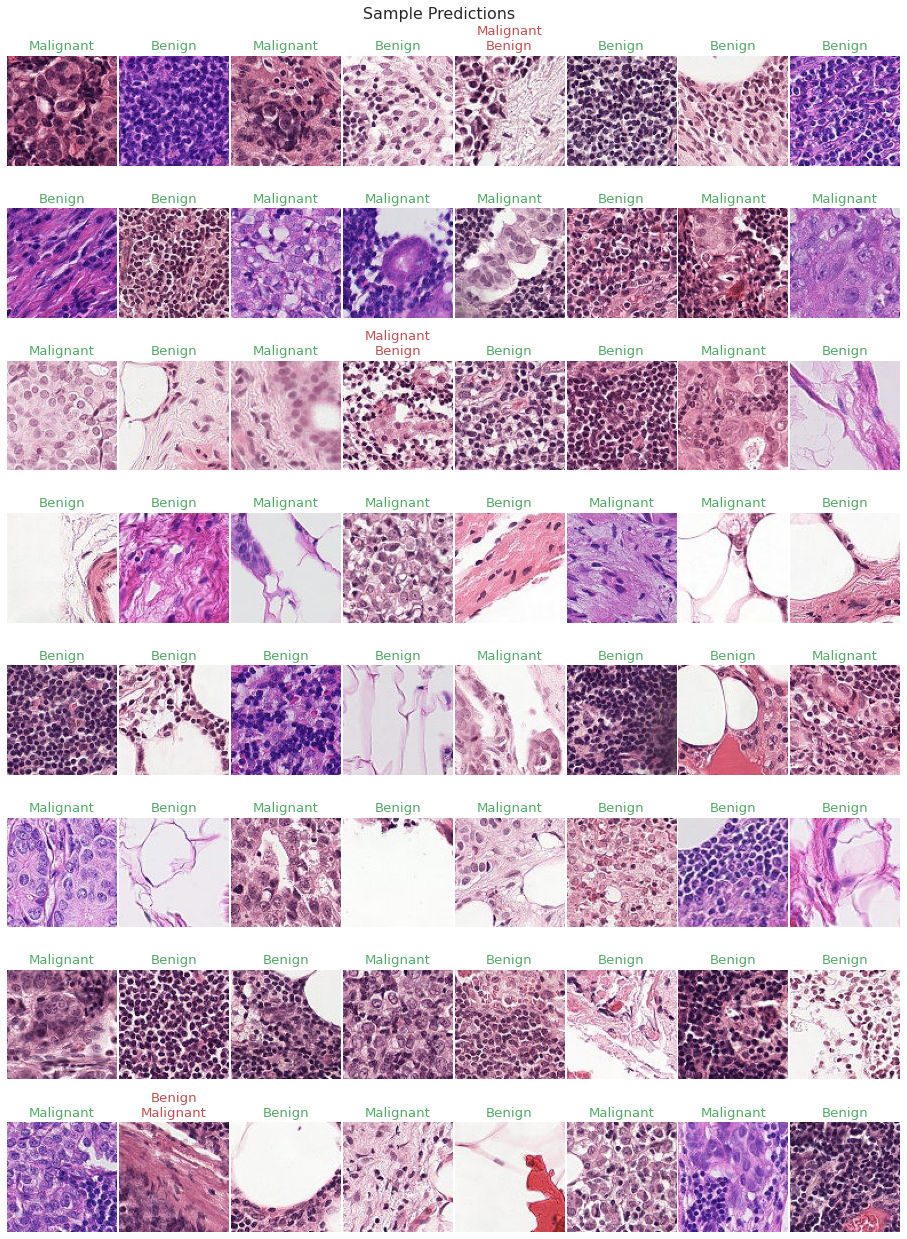

In [41]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)
data_iter = iter(test_loader)

images, labels = data_iter.next()

preds = model.predict(images)
preds = np.argmax(preds, axis=1)

print(images.shape, labels.shape, preds.shape)

display_sample(images.cpu().numpy(), labels.cpu().numpy(), sample_predictions=preds, 
               grid_shape=(8, 8), fig_size=(16, 20), plot_title='Sample Predictions')

In [83]:
del model

## Conclusion
* In this notebook, we wrote a custom dataset to load images from disk
* We also wrote a custom CNN based classifier to classify the cell images as infected or healthy.
* We were able to achieve relatively good performance on test dataset (~91% accuracy).

# <center>---- END ----</center>